# Assignment 1: Labor Supply and Childen

This file answers the questions in assignment #1 for the course Household Behaviour over the Life Cycle. In addition to this notebook, the folder contains the following files:
1. `assignment_1.py`: This file contains most of the functions needed
2. `plots.py`: This file contains the code used to create the plots for the answer

### 0. Importing packages and general set-up

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os

# load local files for the model and plotting
from DynLaborFertModel_old import DynLaborFertModelClass_old
from DynLaborFertModel import DynLaborFertModelClass
import plots

# setting up the plots
plt.rcParams.update({'font.size': 15})
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 15}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#0072BD', '#D95319', '#FAAD26', '#7E2F8E', '#77AC30', '#4DBEEE',
                                                     '#A2142F', '#000000'])  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Finding the value of $\beta_1$

Initialize a model class

In [87]:
par = {}
sol = {}
sim = {}
model = {}

# initialize model class
beta1 = np.array([0.0525])
model['baseline'] = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': beta1}) # set a few number of periods.

par['baseline'] = model['baseline'].par
sol['baseline'] = model['baseline'].sol
sim['baseline'] = model['baseline'].sim

*Solving* the model

In [88]:
model['baseline'].solve()

*Simulating* the model

In [89]:
model['baseline'].simulate()

Making the event study graph

In [82]:
# birth
birth = np.zeros(sim['baseline'].n.shape,dtype=np.int_)
birth[:,1:] = (sim['baseline'].n[:,1:] - sim['baseline'].n[:,:-1]) > 0

# time since birth
periods = np.tile([t for t in range(par['baseline'].simT)],(par['baseline'].simN,1)) # period matrix (simN x simT) going from 0...T-1
time_of_birth = np.max(periods * birth, axis=1) # time of birth for each individual

I = time_of_birth>0
time_of_birth[~I] = -1000 # never has a child
time_of_birth = np.transpose(np.tile(time_of_birth , (par['baseline'].simT,1)))

time_since_birth = periods - time_of_birth

In [83]:
# calculate average outcome across time since birth
min_time = -8
max_time = 8
event_grid = np.arange(min_time,max_time+1)
# print(event_grid)

event_hours = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours[t] = np.mean(sim['baseline'].h[time_since_birth==time])

# relative to period before birth
event_hours_rel = event_hours - event_hours[event_grid==-1]

# percentage from period before birth
event_hours_percent = 100*(event_hours/event_hours[event_grid==-1] - 1)

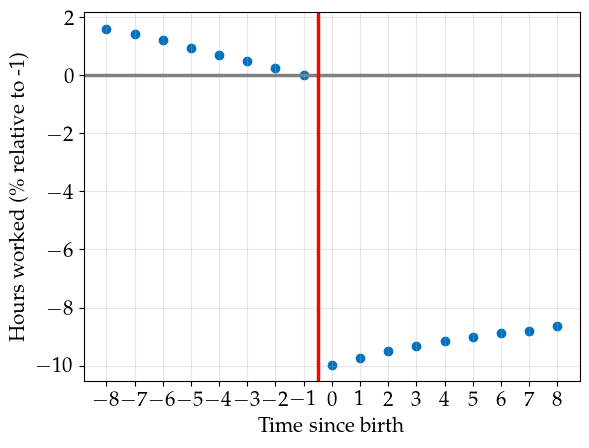

In [84]:
fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_percent)
ax.axhline(y=0,color='gray')
ax.axvline(x=-0.5,color='red')
ax.grid(True, alpha = 0.3)
ax.set(xlabel='Time since birth',ylabel=f'Hours worked (\% relative to -1)',xticks=event_grid);

save = False
if save:
    figure_path = "figs"
    fig.savefig(os.path.join(figure_path, 'event_study_graph.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Using a numerical optimizer (not currently converging)

In [81]:
# write a function that choose beta1 to minimize the distance of event_hours_percent to 10%
def objective(beta1):
    # initialize model class
    np.random.seed(9210)
    model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': beta1}) # set a few number of periods.

    par = model.par
    sol = model.sol
    sim = model.sim

    model.solve()
    model.simulate()
    
    # time since birth
    birth = np.zeros(sim.n.shape,dtype=np.int_)
    birth[:,1:] = (sim.n[:,1:] - sim.n[:,:-1]) > 0

    periods = np.tile([t for t in range(par.simT)],(par.simN,1)) # period matrix (simN x simT) going from 0...T-1
    time_of_birth = np.max(periods * birth, axis=1) # time of birth for each individual

    I = time_of_birth>0
    time_of_birth[~I] = -1000 # never has a child
    time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))

    time_since_birth = periods - time_of_birth
    
    # calculate average outcome across time since birth
    min_time = -8
    max_time = 8
    event_grid = np.arange(min_time,max_time+1)

    event_hours = np.nan + np.zeros(event_grid.size)
    for t,time in enumerate(event_grid):
        event_hours[t] = np.mean(sim.h[time_since_birth==time])

    # percentage from period before birth
    event_hours_percent = 100*(event_hours/event_hours[event_grid==-1] - 1)

    objective = (event_hours_percent[event_grid==0] - 10)**2

    return objective

from scipy.optimize import minimize
def find_beta1():
    beta1_init = np.array([0.05])

    bounds = ((0.0,1.0),)

    res = minimize(objective,beta1_init,bounds=bounds,method='trust-constr')

    beta1_opt = res.x[0]
    return beta1_opt

In [79]:
objective_value = objective(0.053)
print(objective_value)

[401.35704784]


In [82]:
beta1_opt = find_beta1()

KeyboardInterrupt: 

In [57]:
print(beta1_opt)

0.05


### 2. Exogenous income

I solve this by making a new function called `exo_income` which contains the income process. This function is then added to the income line in `value_of_choice` function.

In [198]:
model['exoy'] = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': beta1,
                                    'a_exo': 0.1, 'b_exo': 0.01}) # set a few number of periods.

par['exoy'] = model['exoy'].par
sol['exoy'] = model['exoy'].sol
sim['exoy'] = model['exoy'].sim

model['exoy'].solve()
model['exoy'].simulate()

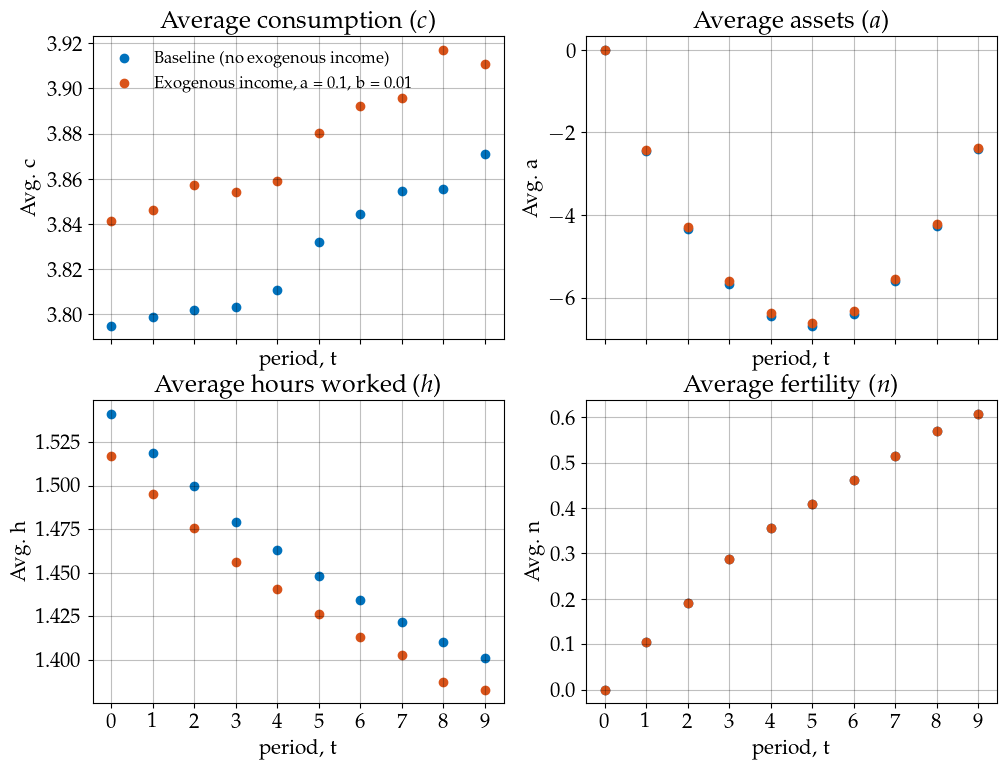

In [ ]:
# plot behavior
fig, ax = plt.subplots(2,2,figsize=(2/3*17.5,13*2/3), sharex=True)
ax = ax.flatten()

var_name = {'c': r'Average consumption ($c$)', 'a': r'Average assets ($a$)', 
            'h': r'Average hours worked ($h$)', 'n': r'Average fertility ($n$)'}

# for i, var in enumerate(('c','a','h','n')):
for i, (var, value) in enumerate(var_name.items()):   
    # fig, ax = plt.subplots()
    ax[i].scatter(range(par['baseline'].simT),np.mean(getattr(sim['baseline'],var),axis=0),label='Baseline (no exogenous income)')
    ax[i].scatter(range(par['exoy'].simT),np.mean(getattr(sim['exoy'],var),axis=0),label=r'Exogenous income, a = 0.1, b = 0.01')
    ax[i].set(xlabel='period, t',ylabel=f'Avg. {var}',xticks=range(par['baseline'].simT));
    ax[i].set_title(var_name[var])
    if i == 0:
        ax[i].legend(frameon=False, fontsize = 12)

save = False
if save:
    figure_path = "figs"
    fig.savefig(os.path.join(figure_path, 'life_cycle_profile.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### 3. Childcare cost

I now include a child care cost in the model. I do this by introducting an additional parameter $\theta$ into the `value_of_choice` function. For the case of $\theta = 0.0$, the model is equal to the baseline.

In [200]:
model['childcare'] = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': beta1,
                                    'theta': 0.05}) # set a few number of periods.

par['childcare'] = model['childcare'].par
sol['childcare'] = model['childcare'].sol
sim['childcare'] = model['childcare'].sim

model['childcare'].solve()
model['childcare'].simulate()

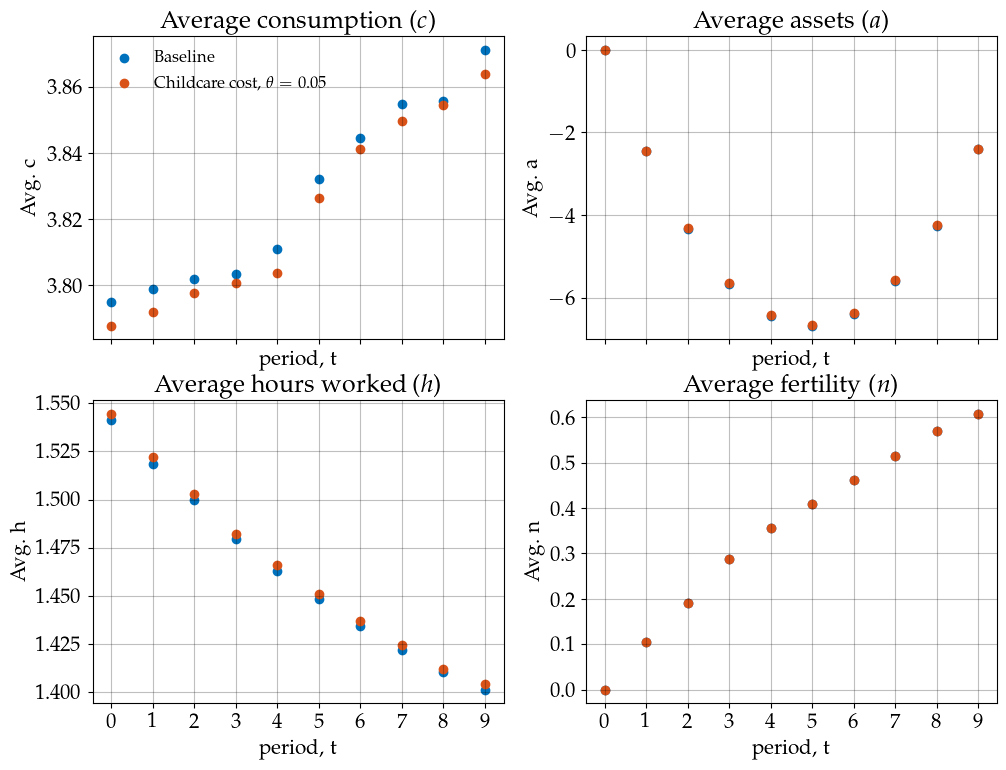

In [202]:
fig = plots.compare_lifecycle('baseline','childcare', sim, par, labels = ['Baseline',r'Childcare cost, $\theta = 0.05$'])

save = True
if save:
    figure_path = "figs"
    fig.savefig(os.path.join(figure_path, 'baseline_vs_childcare.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

Now compute the Marshall elasticities in baseline and childcare cost model by making a 1 percent permanent wage change. 

Start by the *baseline* model:

In [203]:
# simulate Marshall elasticity in the first period
model['baseline_1pct'] = model['baseline'].copy()
model['baseline_1pct'].par.w_vec[:] = model['baseline_1pct'].par.w_vec[:]*1.01

model['baseline_1pct'].solve()
model['baseline_1pct'].simulate()

ela_Mi_baseline = (model['baseline_1pct'].sim.h - model['baseline'].sim.h)/model['baseline'].sim.h*100

Now the *childcare cost model*

In [204]:
# simulate Marshall elasticity in the first period
model['childcare_1pct'] = model['childcare'].copy()
model['childcare_1pct'].par.w_vec[:] = model['childcare_1pct'].par.w_vec[:]*1.01

model['childcare_1pct'].solve()
model['childcare_1pct'].simulate()

ela_Mi_childcare = (model['childcare_1pct'].sim.h - model['childcare'].sim.h)/model['childcare'].sim.h*100

In [205]:
print(f"Average Marhsall elasticity, baseline: {np.mean(ela_Mi_baseline)}")
print(f"Average Marhsall elasticity, childcare: {np.mean(ela_Mi_childcare)}")

Average Marhsall elasticity, baseline: -0.1980427200877065
Average Marhsall elasticity, childcare: -0.20239270995951614


### 5. Random spouse arrival

In [90]:
# initialize model class
beta1 = np.array([0.0525])
model['rand_spouse'] = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 
                                                'beta_1': beta1, 'p_spouse': 0.8}) # set a few number of periods.

par['rand_spouse'] = model['rand_spouse'].par
sol['rand_spouse'] = model['rand_spouse'].sol
sim['rand_spouse'] = model['rand_spouse'].sim

model['rand_spouse'].solve()
model['rand_spouse'].simulate()

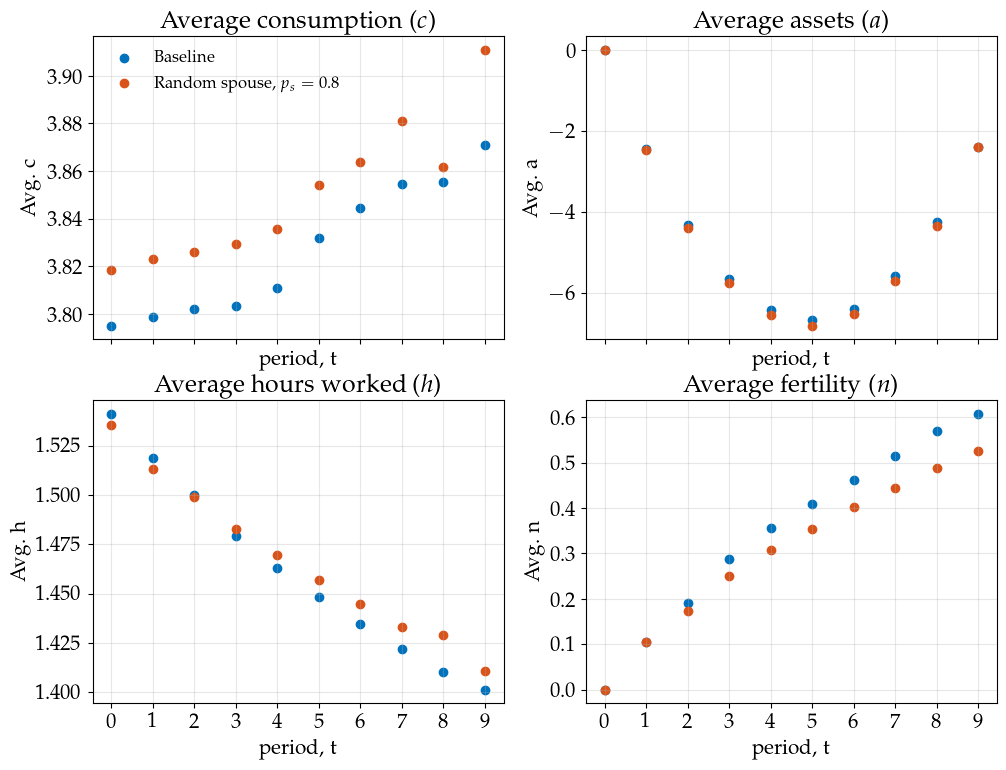

In [91]:
fig = plots.compare_lifecycle('baseline','rand_spouse', sim, par, labels = ['Baseline',r'Random spouse, $p_s = 0.8$'])


### Appendix: Debugging

Compare a version of the model with random spouse arrival with a model without it.

In [ ]:
par = {}
sol = {}
sim = {}
model = {}

# initialize model class
beta1 = np.array([0.0525])
model['baseline'] = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': beta1}) # set a few number of periods.

par['baseline'] = model['baseline'].par
sol['baseline'] = model['baseline'].sol
sim['baseline'] = model['baseline'].sim

In [ ]:
# initialize model class
beta1 = np.array([0.0525])
model['baseline_old'] = DynLaborFertModelClass_old(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': beta1}) # set a few number of periods.

par['baseline_old'] = model['baseline_old'].par
sol['baseline_old'] = model['baseline_old'].sol
sim['baseline_old'] = model['baseline_old'].sim

model['baseline_old'].solve()

In [ ]:
plt.plot(model['baseline'].par.a_grid,model['baseline'].sol.c[1,1,0,:,0]) # consumption as function of cash-on-hand for unmarried person
plt.plot(model['baseline_old'].par.a_grid,model['baseline_old'].sol.c[1,0,:,0])